In [1]:
import jax
import jax.numpy as jnp
from jax.experimental import optimizers
import os
import h5py
import numpy as onp
import time
import cardiax
import deepx
from deepx import optimise
import helx
from helx.types import Optimiser
import json
import wandb
import pickle
import IPython
from IPython.display import display
from IPython.display import display_javascript
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.animation as animation
import helx
from matplotlib import rc
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import matplotlib.patches as mpatches

rc('animation', html='jshtml')
rc('text', usetex=False)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [11]:
def grad_loss(y_hat, y):

    # first derivative
    grad_y_hat_x = cardiax.solve.gradient(y_hat, -1)
    grad_y_hat_y = cardiax.solve.gradient(y_hat, -2)
    grad_y_x = cardiax.solve.gradient(y, -1)
    grad_y_y = cardiax.solve.gradient(y, -2)
    grad_loss_x = (grad_y_hat_x - grad_y_x) ** 2  # rmse
    grad_loss_y = (grad_y_hat_y - grad_y_y) ** 2  # rmse
    grad_loss = grad_loss_x + grad_loss_y
    return grad_loss


def compare(y_hat, y, diffusivity=None, times=None, **kwargs):  
    rows = 3
    cols = 3 + int(diffusivity is not None)
    fig, ax = plt.subplots(
        rows,
        cols,
        figsize=(kwargs.pop("figsize", None) or (25, 15)),
    )
    ax = onp.array(ax)
    vmin = kwargs.pop("vmin", 0)
    vmax = kwargs.pop("vmax", 1)
    cmap = kwargs.pop("cmap", "Blues")
    title = kwargs.pop("title", "")
    
    
    l1 = jnp.abs(y_hat - y)# / (y.max() - y.min())
    states = (y_hat, y, l1)
    
    pad = 5 # in points
    col_names = cardiax.solve.State._fields + ("σ", )
    for _ax, col in zip(ax[0], col_names):
        _ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
    
    row_names = ("Prediction", "Target", "Absolute error",)
    for _ax, row in zip(ax[:, 0], row_names):
        _ax.annotate(row, xy=(0, 0.5), xytext=(-_ax.yaxis.labelpad - pad, 0),
                    xycoords=_ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)
    
    for r in range(rows):
        state = cardiax.solve.State(*(states[r].squeeze()))
        for c in range(cols - int(diffusivity is not None)):
            im = ax[r, c].imshow(state[c], vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
            ax[r, c].set_xlabel("x [cm]")
            ax[r, c].set_ylabel("y [cm]")
            ax[r, c].xaxis.set_major_formatter(
                FuncFormatter(lambda d, _: "{:.1f}".format(d / 100 * 1200 / 256))
            )
            ax[r, c].yaxis.set_major_formatter(
                FuncFormatter(lambda d, _: "{:.1f}".format(d / 100 * 1200 / 256))
            )
            cb = plt.colorbar(im, ax=ax[r, c])
#             if r >= 2:
#                 cb.ax.set_yticklabels(["{0:.3f}%".format(i / 100) for i in cb.get_ticks()]) # set ticks of your format
                

        if diffusivity is not None:
            im = ax[r, -1].imshow(diffusivity, cmap="gray")
            ax[r, -1].set_xlabel("x [cm]")
            ax[r, -1].set_ylabel("y [cm]")
            ax[r, -1].xaxis.set_major_formatter(
                FuncFormatter(lambda d, _: "{:.1f}".format(d / 100 * 1200 / 256))
            )
            ax[r, -1].yaxis.set_major_formatter(
                FuncFormatter(lambda d, _: "{:.1f}".format(d / 100 * 1200 / 256))
            )            
            clb = plt.colorbar(im, ax=ax[r, -1])
            clb.ax.set_title("[cm^2/ms]")
    
    fig.suptitle(title)
    fig.tight_layout()
    return fig, ax


def plot_loss(l1, j, ax=None, **kwargs):
    cmap = kwargs.pop("cmap", matplotlib.cm.get_cmap("Blues"))
    colors = reversed([cmap(i) for i in jnp.linspace(0.3, 1, 6)])  #cmap(0.70), cmap(0.5), cmap(0.30)
    
    if ax is None:
        figsize = kwargs.pop("figsize", None) or (10, 5)
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = None
    
    losses = (*l1.T, *j.T)
    ax.stackplot(jnp.arange(0, len(losses[0])), *losses, colors=colors, labels=("recon-v", "recon-w", "recon-u", "grad-v", "grad-w", "grad-u"), edgecolor="white")
    ax.set_xlim(0, len(losses[0]) - 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Mean squared error")
    ax.xaxis.set_major_formatter(
            FuncFormatter(lambda d, _: "{:.1f}ms".format(d * 5))
        ) 
    ax.legend(loc="upper left")
    return fig, ax


def load_diffusivity(filename, normalise=True):
    with h5py.File(filename, "r") as sequence:
        diffusivity = onp.array(sequence["diffusivity"])
        if normalise:
            diffusivity = diffusivity * 500
        return diffusivity

    
def take(filename, t, length, normalise=False):
    with h5py.File(filename, "r") as sequence:
        states = onp.array(
            sequence["states"][
                t : t + (2 + length)
            ]
        )
        diffusivity = onp.array(sequence["diffusivity"])
        if normalise:
            diffusivity = diffusivity * 500
        diffusivity = onp.tile(diffusivity[None, None], (2, 1, 1, 1))
        xs = onp.concatenate([states[:2], diffusivity], axis=-3)
        ys = states[2:]
        xs = xs[None, None]
        ys = ys[None, None]
        print(xs.shape, ys.shape)
        return xs, ys
    
    
def animate_state(a, d, filename=None):
    states_a = [cardiax.solve.State(*x) for x in a.squeeze()]
    anim = cardiax.plot.animate_state(states_a, d, cmap="Blues", vmin=0, vmax=1)
    display(anim)
    if filename is not None:
        anim.save("data/{}".format(filename))
    return anim


def load_model(url):
    train_state = deepx.optimise.TrainState.restore(url)
    hparams = train_state.hparams
    model = deepx.resnet.ResNet(hparams.hidden_channels, 1, hparams.depth)
    opt = optimizers.adam(0.001)
    params = opt.params_fn(train_state.opt_state)
    return model, hparams, params


@partial(
    jax.pmap,
    in_axes=(None, None, 0, 0),
    static_broadcasted_argnums=(0, 1),
    axis_name="device",
)
def infer_with_clip(model, n_refeed, params, xs, clip):
    def body_fun(inputs, i):
        x = inputs
        y_hat = model.apply(params, x)
        y_hat = jnp.clip(y_hat, clip)
        x = deepx.optimise.refeed(x, y_hat)  #  add the new pred to the inputs
        return x, y_hat

    _, ys_hat = jax.lax.scan(body_fun, xs, xs=jnp.arange(n_refeed))
    ys_hat = jnp.swapaxes(jnp.squeeze(ys_hat), 0, 1)
    return ys_hat


def evaluate_with_clip(url, xs, n_refeed, ys=None, clip=0.1):
    model, hparams, params = load_model(url)
    start = time.time()
    ys_hat = infer_with_clip(model, n_refeed, params, xs, clip)
    print("Solved forward propagation to {}ms in: {}s".format(n_refeed / 0.01, time.time() - start))
    ys_hat = jnp.swapaxes(ys_hat, -3, -4)[None]
    loss = None
    if ys is not None:
        assert ys_hat.shape == ys.shape, "ys_hat and ys are of different shapes {} and {}".format(ys_hat.shape, ys.shape)
        loss = jnp.mean((ys_hat - ys) ** 2, axis=(0, 1, 3, 4, 5))
    return ys_hat, loss


def evaluate(url, xs, n_refeed, ys=None):
    model, hparams, params = load_model(url)
    start = time.time()
    ys_hat = deepx.optimise.infer(model, n_refeed, params, xs)
    print("Solved forward propagation to {}ms in: {}s".format(n_refeed / 0.01, time.time() - start))
    if ys_hat.shape[0] == 1:
        ys_hat = jnp.swapaxes(ys_hat, -3, -4)[None]
    loss = None
    if ys is not None:
        assert ys_hat.shape == ys.shape, "ys_hat and ys are of different shapes {} and {}".format(ys_hat.shape, ys.shape)
        loss = jnp.mean((ys_hat - ys) ** 2, axis=(0, 1, 4, 5))
    return ys_hat, loss


def test(url, n_refeed, n_samples=10, seed=0):
    rng = jax.random.PRNGKey(seed)
    dataset = deepx.dataset.Dataset("/home/epignatelli/repos/cardiax/experiments/training/data/val", 2, n_refeed, 5, batch_size=1)
    losses = []
    for i in range(n_samples):
        batch = dataset.sample(rng)
        xs, ys = deepx.optimise.preprocess(batch)
        ys_hat, _ = evaluate(url, xs, n_refeed)
        l1 = jnp.mean(jnp.square(ys_hat - ys), axis=(0, 1, 3, 4, 5))
        losses += [l1]
        rng, _ = jax.random.split(rng)
    return losses


def plot_accuracy(losses, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    else:
        fig = None
    losses = jnp.array(losses)
    
    # loss in time
    mean = jnp.mean(losses, axis=0)
    std = jnp.std(losses, axis=0)
    ax.plot(mean, linestyle="dashed", label="mean")
    ax.fill_between(jnp.arange(0, len(losses.T)), mean - std, mean + std, alpha=0.1, label="std")
    ax.plot(losses.T, alpha=0.1, c="gray")
    ax.set_xlim(0, len(losses.T) - 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Mean squared error")
    ax.xaxis.set_major_formatter(
            FuncFormatter(lambda d, _: "{:.1f}ms".format(d * 5))
        ) 
    handles, labels = ax.get_legend_handles_labels()
    handles += [mpatches.Patch(color='gray', label='samples')]
    ax.legend(handles=handles, loc="upper left")
    ax.set_title("Distribution of error in time on {} samples".format(len(mean)))
    return fig, ax


def get_losses(ys_hat, ys):
    l1 = jnp.mean(jnp.square((ys_hat - ys)), axis=(0, 1, 4, 5))
    j = jnp.mean(jnp.square(grad_loss(ys_hat, ys)), axis=(0, 1, 4, 5))
    return l1, j

## Setup model

In [3]:
FILENAME = "data/linear.hdf5"
N_REFEED = 100
URL = "p3aetobr/10351"  # TOP

## Test linear wave propagation

In [4]:
xs_linear, ys_linear = take(FILENAME, 0, N_REFEED, True)
ys_hat_linear, loss_linear = evaluate(URL, xs_linear, N_REFEED, ys_linear)

(1, 1, 2, 4, 256, 256) (1, 1, 100, 3, 256, 256)
Solved forward propagation to 10000.0ms in: 7.275511264801025s


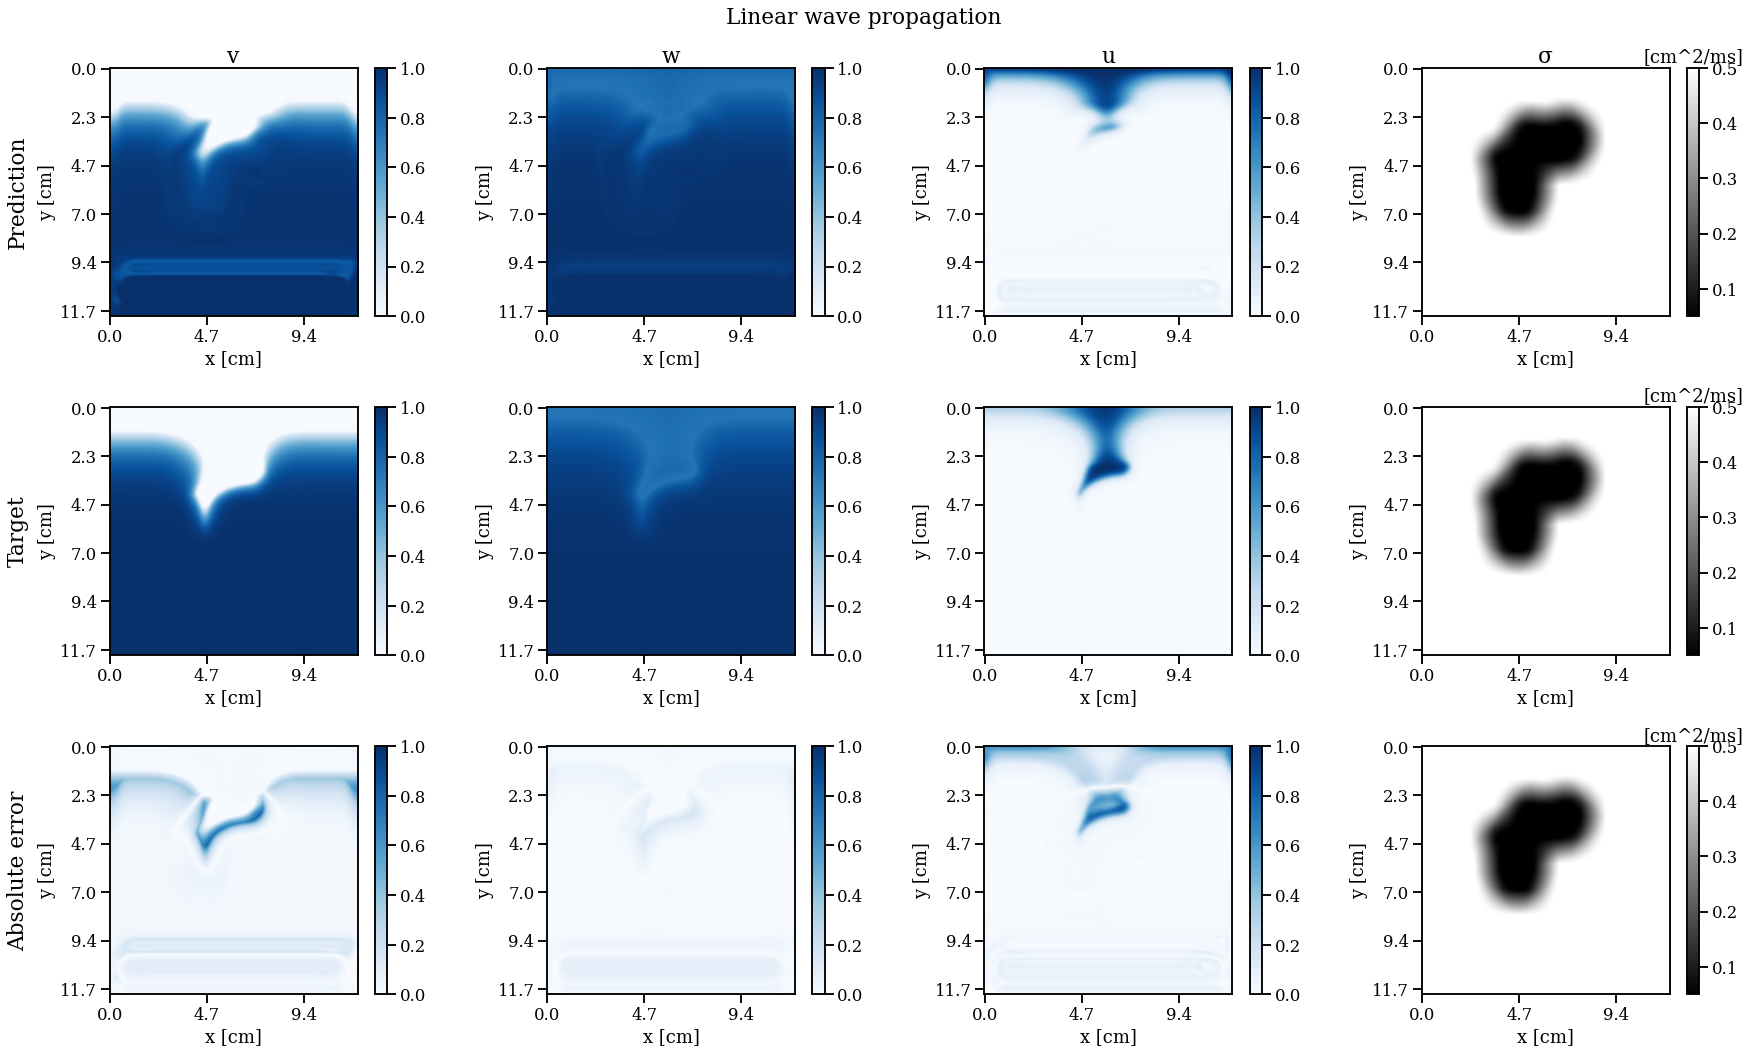

In [5]:
l1_linear, j_linear = get_losses(ys_hat_linear, ys_linear)

d = load_diffusivity(FILENAME)
# animate_state(ys_hat, d)
# animate_state(ys, d)
with sns.plotting_context("talk"):
    fig, ax = compare(ys_hat_linear[:, :, 90], ys_linear[:, :, 90], d, title="Linear wave propagation")
    os.makedirs("results/longer_rollouts", exist_ok=True)
    fig.savefig("results/longer_rollouts/linear.png")
    fig.savefig("results/longer_rollouts/linear.svg")
    plt.show()

## Spiral wave propagation

In [6]:
FILENAME = "data/spiral.hdf5"
xs_spiral, ys_spiral = take(FILENAME, 82, N_REFEED, True)
ys_hat_spiral, loss_spiral = evaluate(URL, xs_spiral, N_REFEED, ys_spiral)

(1, 1, 2, 4, 256, 256) (1, 1, 100, 3, 256, 256)
Solved forward propagation to 10000.0ms in: 6.259459733963013s


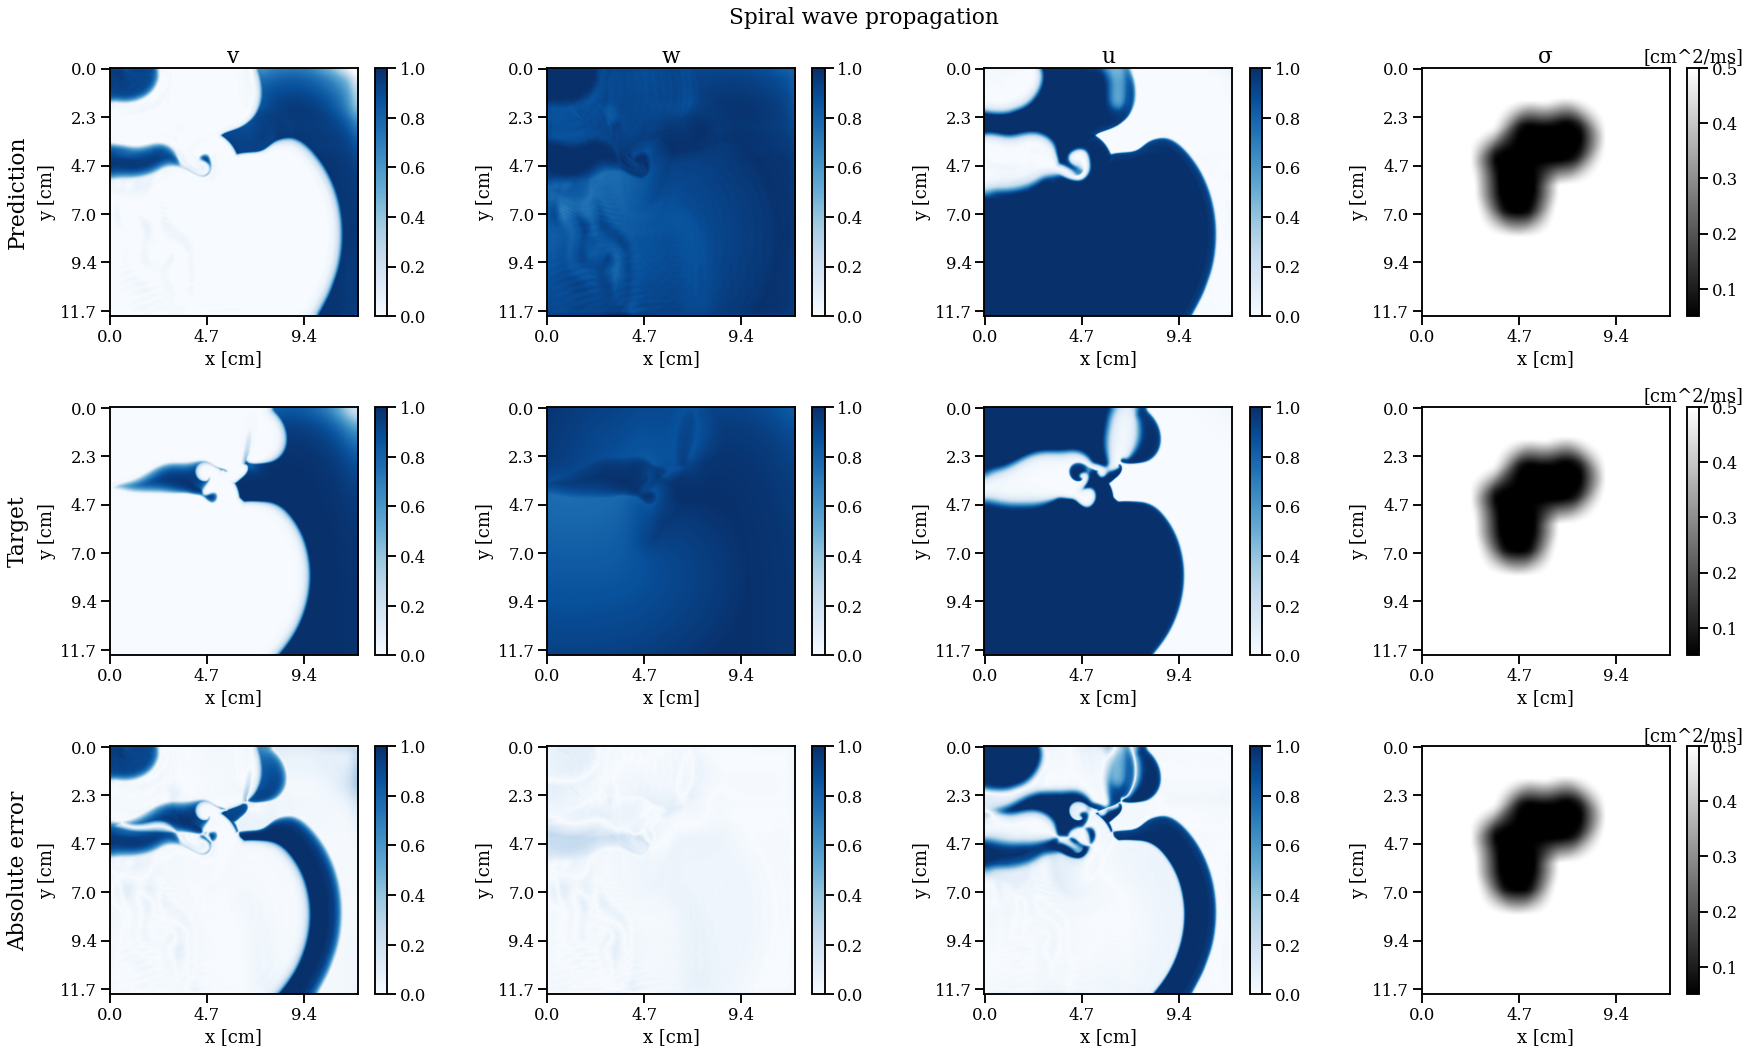

In [7]:
l1_spiral, j_spiral = get_losses(ys_hat_spiral, ys_spiral)

d = load_diffusivity(FILENAME)
# animate_state(ys_hat_spiral, d)
# animate_state(ys_spiral, d)
with sns.plotting_context("talk"):
    fig, ax = compare(ys_hat_spiral[:, :, 90], ys_spiral[:, :, 90], d, title="Spiral wave propagation")
    os.makedirs("results/longer_rollouts", exist_ok=True)
    fig.savefig("results/longer_rollouts/spiral.png")
    fig.savefig("results/longer_rollouts/spiral.svg")
    plt.show()

## Chaotic

In [9]:
FILENAME = "data/spiral.hdf5"
xs_chaotic, ys_chaotic = take(FILENAME, 280, N_REFEED, True)
ys_hat_chaotic, loss_chaotic = evaluate(URL, xs_chaotic, N_REFEED, ys_chaotic)

(1, 1, 2, 4, 256, 256) (1, 1, 100, 3, 256, 256)
Solved forward propagation to 10000.0ms in: 6.291414737701416s


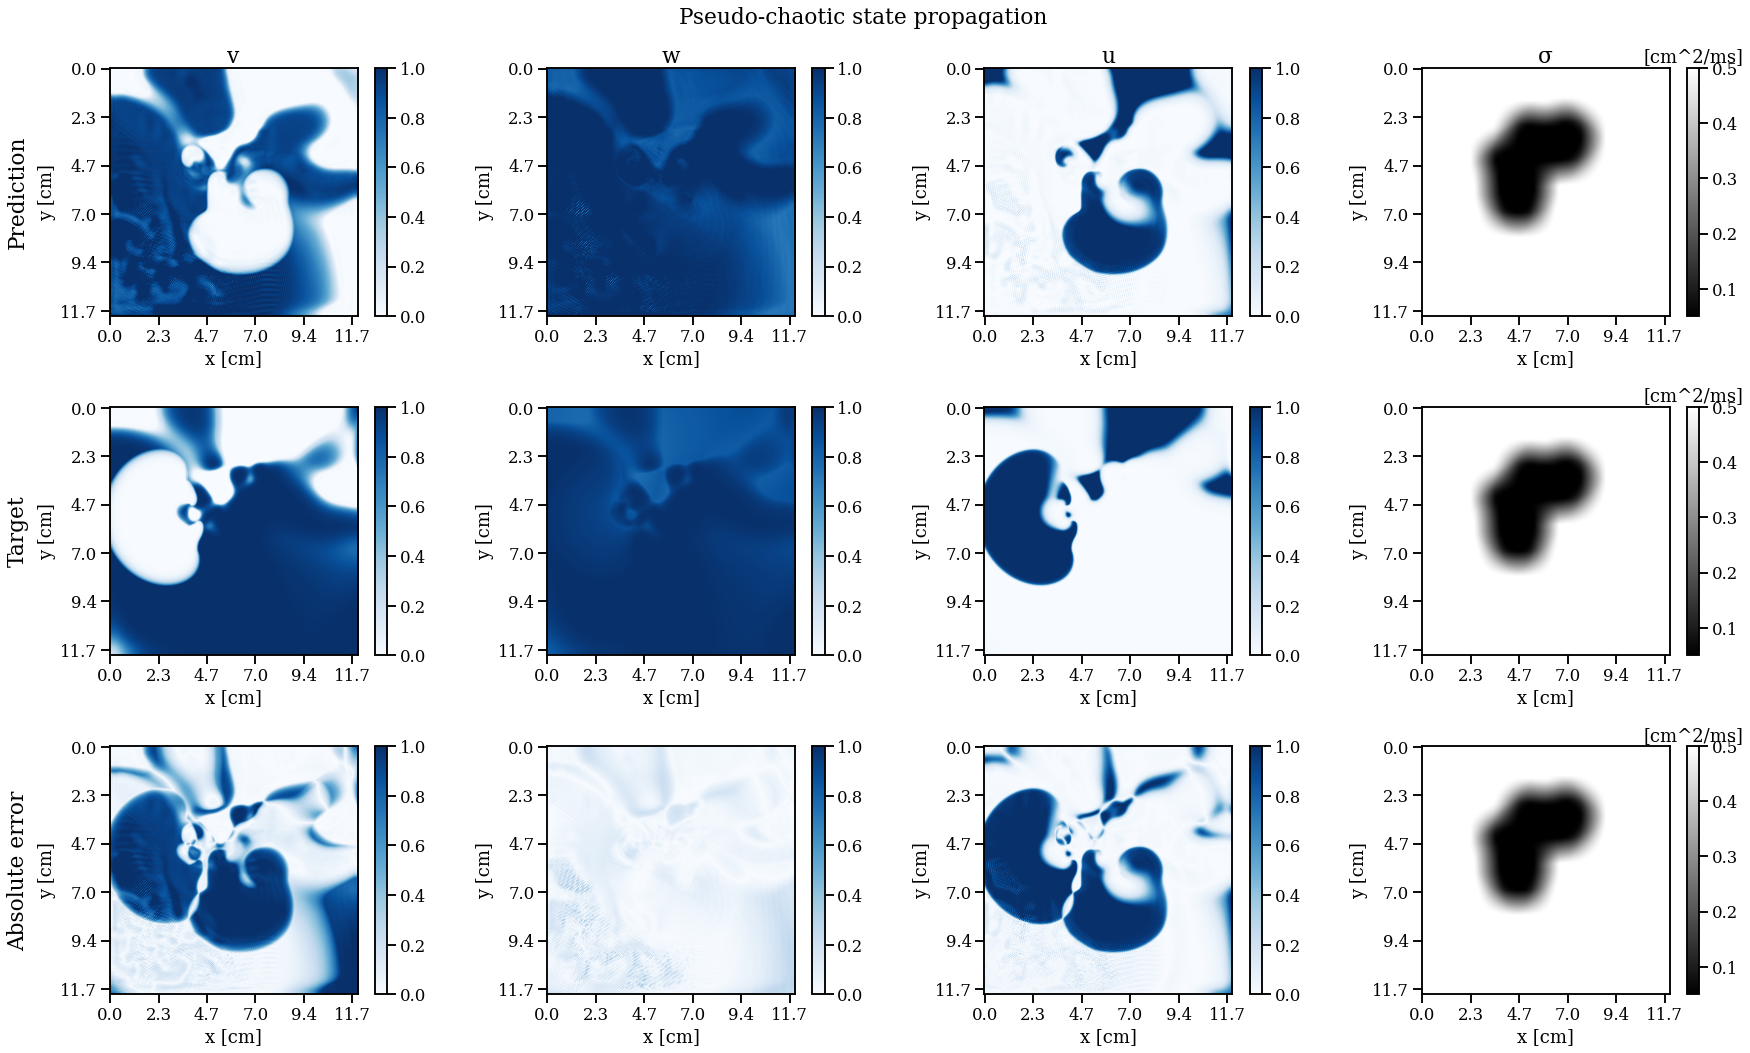

In [10]:
l1_chaotic, j_chaotic = get_losses(ys_hat_chaotic, ys_chaotic)

d = load_diffusivity(FILENAME)
# animate_state(ys_hat_chaotic, d)
# animate_state(ys_chaotic, d)
with sns.plotting_context("talk"):
    fig, ax = compare(ys_hat_chaotic[:, :, 90], ys_chaotic[:, :, 90], d, title="Pseudo-chaotic state propagation")
    os.makedirs("results/longer_rollouts", exist_ok=True)
    fig.savefig("results/longer_rollouts/chaotic.png")
    fig.savefig("results/longer_rollouts/chaotic.svg")    

## Plot test summary

In [12]:
losses = test(URL, N_REFEED, 100)

Solved forward propagation to 10000.0ms in: 6.303640365600586s
Solved forward propagation to 10000.0ms in: 6.297428607940674s
Solved forward propagation to 10000.0ms in: 6.408268213272095s
Solved forward propagation to 10000.0ms in: 6.319822549819946s
Solved forward propagation to 10000.0ms in: 6.302030801773071s
Solved forward propagation to 10000.0ms in: 6.32013463973999s
Solved forward propagation to 10000.0ms in: 6.31205940246582s
Solved forward propagation to 10000.0ms in: 6.334241151809692s
Solved forward propagation to 10000.0ms in: 6.412819147109985s
Solved forward propagation to 10000.0ms in: 6.315685272216797s
Solved forward propagation to 10000.0ms in: 6.302422285079956s
Solved forward propagation to 10000.0ms in: 6.326733827590942s
Solved forward propagation to 10000.0ms in: 6.3107123374938965s
Solved forward propagation to 10000.0ms in: 6.326783657073975s
Solved forward propagation to 10000.0ms in: 6.42618727684021s
Solved forward propagation to 10000.0ms in: 6.34763717651

## Figure

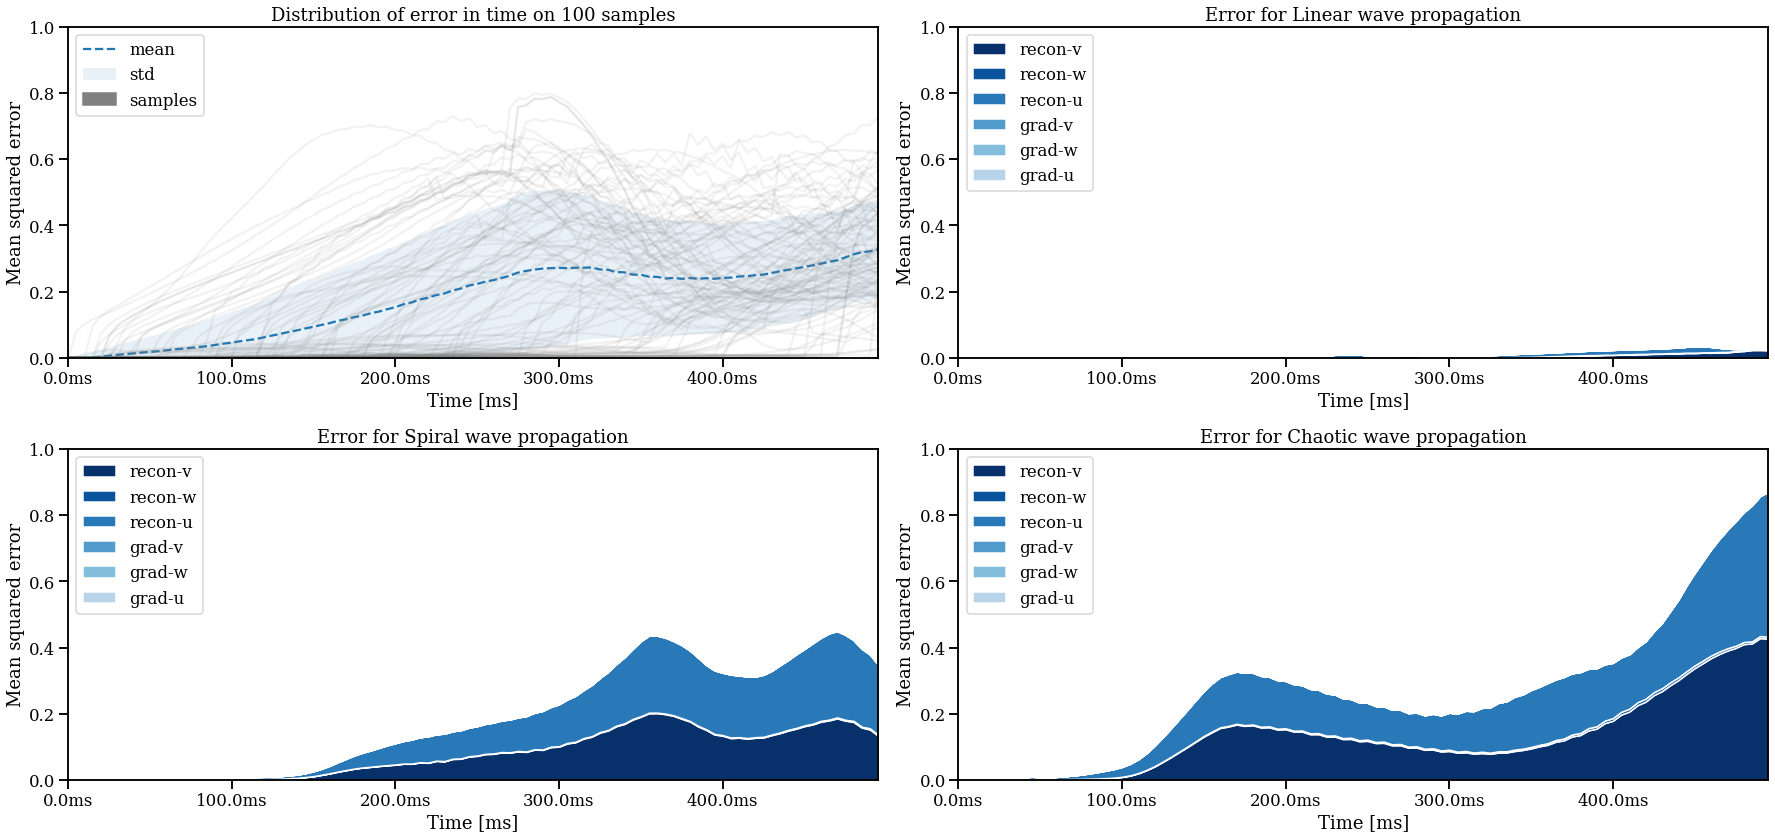

In [14]:
with sns.plotting_context("talk"):
    fig, axes = plt.subplots(2, 2, figsize=(25, 12))

    l1 = (l1_linear, l1_spiral, l1_chaotic)
    j = (j_linear, j_spiral, j_chaotic)
    titles = ["Error for {} wave propagation".format(s) for s in ["Linear", "Spiral", "Chaotic"]]

    plot_accuracy(losses, ax=axes[0, 0])
    plot_loss(l1_linear, j_linear, ax=axes[0, 1], vmax=1)
    axes[0, 1].set_title(titles[0])
    plot_loss(l1_spiral, j_spiral, ax=axes[1, 0], vmax=1)
    axes[1, 0].set_title(titles[1])
    plot_loss(l1_chaotic, j_chaotic, ax=axes[1, 1], vmax=1)
    axes[1, 1].set_title(titles[2])
    plt.tight_layout()
    fig.savefig("results/longer_rollouts/loss.png")
    fig.savefig("results/longer_rollouts/loss.svg")
    plt.show()